In [46]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from torch.autograd import grad
import numpy as np


import matplotlib.pyplot as plt

In [33]:

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'device: {device}')

device: cpu


In [34]:
# Generate synthetic sensor data

N_obs = 10
t_obs = torch.linspace(0, 5, N_obs).unsqueeze(-1).to(device)
u_true = (t_obs**2) / 2 + t_obs
noise_std = 0.1
u_obs = u_true + noise_std * torch.randn_like(u_true)

In [35]:
# Collocation points 

N_f = 100
t_f = torch.linspace(0, 5, N_f).unsqueeze(-1).to(device).requires_grad_(True)


# Initial Point

t_ic = torch.tensor([[0.0]], requires_grad=True).to(device)

In [47]:

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 1)
        self.act = torch.tanh

    def forward(self, t):
        z = self.act(self.layer1(t))
        x = self.act(self.layer2(z))
        return self.layer3(x)

pinn = PINN().to(device)

In [56]:
# Pyro probabilistic model

def model(t_obs, u_obs,t_f, t_ic):
    
    # Priors on all network parameters

    for name, param in pinn.named_parameters():
        pyro.sample(name, dist.Normal(0., 1.).expand(param.shape).to_event(param.dim()))

    # Sensor Likelihood

    u_pred_obs = pinn(t_obs)
    pyro.sample("obs", dist.Normal(u_pred_obs.squeeze(-1), noise_std).to_event(1),obs=u_obs.squeeze(-1))


    # Physics constraint

    u_pred_f = pinn(t_f)
    du_dt = torch.autograd.grad(u_pred_f, t_f, grad_outputs=torch.ones_like(u_pred_f), create_graph=True)[0]
    residual = du_dt - t_f
    
    # The factor strength (lambda) can be tuned:
    pyro.factor("physics", -1e3 * residual.pow(2).sum())


    # Initial‐condition residual factor

    u_pred_ic = pinn(t_ic)
    residual_ic = u_pred_ic - 0.0
    # penalize squared IC error
    pyro.factor("ic", -1e3 * residual_ic.pow(2).sum())


In [57]:
# Run HMC (NUTS)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=100)
mcmc.run(t_obs, u_obs, t_f,t_ic)

Warmup:   0%|          | 0/300 [00:00, ?it/s]

RuntimeError: One of the differentiated Tensors does not require grad
     Trace Shapes:        
      Param Sites:        
     Sample Sites:        
layer1.weight dist | 20  1
             value | 20  1
  layer1.bias dist | 20   
             value | 20   
layer2.weight dist | 20 20
             value | 20 20
  layer2.bias dist | 20   
             value | 20   
layer3.weight dist |  1 20
             value |  1 20
  layer3.bias dist |  1   
             value |  1   
          obs dist | 10   
             value | 10   

In [50]:
# Extract posterior samples

samples = mcmc.get_samples()

In [51]:
# Posterior predictive on a fine grid
t_test = torch.linspace(0, 5, 50).unsqueeze(-1).to(device)
predictions = []
for i in range(50):  # take first 50 posterior samples
    # Load sampled parameters into the network
    for name, param in pinn.named_parameters():
        param.data = samples[name][i].reshape(param.shape).to(device)
    with torch.no_grad():
        predictions.append(pinn(t_test).cpu().numpy())
predictions = np.stack(predictions, axis=0)  # shape [50, 50, 1]

mean_pred = predictions.mean(axis=0).squeeze(-1)
std_pred = predictions.std(axis=0).squeeze(-1)

In [54]:
print("Posterior mean at test points:", mean_pred)
print("Posterior std at test points:", std_pred)

Posterior mean at test points: [0.18159981 0.22396219 0.25427514 0.3066337  0.35801533 0.3599923
 0.3084689  0.24873817 0.21310702 0.20420265 0.20361961 0.20143518
 0.20775133 0.22593121 0.24647602 0.26164085 0.27178332 0.28430063
 0.30209866 0.3197231  0.33465087 0.347452   0.358601   0.3687613
 0.3787323  0.3889711  0.39960572 0.41075057 0.4227216  0.43599045
 0.45095566 0.467733   0.48610175 0.5055978  0.5256609  0.545766
 0.5655021  0.5845882  0.6028642  0.6202482  0.6367112  0.6522498
 0.6668698  0.6805801  0.6933888  0.7053035  0.71633285 0.72648984
 0.73579264 0.74426264]
Posterior std at test points: [3.7523272 3.7703793 3.8379211 3.9111693 3.9654145 4.0745873 4.1729927
 4.1835217 4.1357183 4.0825806 4.042421  4.013292  3.9828563 3.9484336
 3.9190047 3.8995004 3.892661  3.900009  3.9164827 3.9304004 3.9405568
 3.9531271 3.9714425 3.994425  4.0187044 4.0411925 4.06033   4.075982
 4.088897  4.100167  4.1108036 4.1215096 4.1326313 4.144235  4.156218
 4.168407  4.1806245 4.1927266 

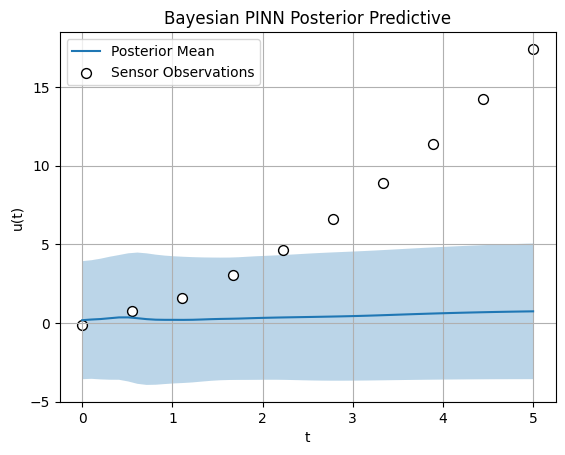

In [55]:
t_test_np = t_test.cpu().numpy().squeeze()

t_obs_np = t_obs.cpu().numpy().squeeze()
u_obs_np = u_obs.cpu().numpy().squeeze()

plt.figure()
plt.plot(t_test_np,mean_pred,label = 'Posterior Mean')

plt.fill_between(t_test_np, mean_pred - std_pred, mean_pred + std_pred, alpha = 0.3)

plt.scatter(t_obs_np, u_obs_np, marker = 'o', edgecolor='k', facecolor = 'white', s = 50, label = 'Sensor Observations')

plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Bayesian PINN Posterior Predictive')
plt.legend()
plt.grid(True)
plt.show()